In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import warnings
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import random
import copy
from sklearn.decomposition import PCA
from sklearn import random_projection
from sklearn.manifold import TSNE, Isomap
from PIL import Image, ImageFilter
import joblib
from sklearn.manifold import TSNE

2023-08-17 19:22:58.541776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = 60
path = 'datasets/anime_faces/'

n = 0
for image in os.listdir(path):
    n += 1

train_images = np.zeros((n, image_size, image_size, 3))

for i, image in enumerate(os.listdir(path)):
    img = Image.open(path + image)
    img = img.resize((image_size, image_size))
    train_images[i] = np.array(img)
    train_images[i] = train_images[i] / 255.0


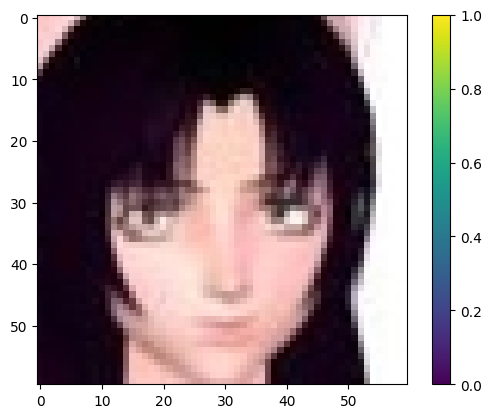

63565


In [3]:
plt.figure()
plt.imshow(train_images[8])
plt.colorbar()
plt.show()
print(n)



In [35]:
latent_dim = 20
sample_size = 4000

rf = RandomForestRegressor(n_estimators=150, max_depth=7, random_state=0, max_samples=0.05, n_jobs=-1)
scaler = MinMaxScaler()
# projection = Isomap(n_neighbors=3, n_components=latent_dim)
# projection = random_projection.SparseRandomProjection()
# projection = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, learning_rate='auto')
projection = PCA(n_components=latent_dim)


subsample_indices = np.random.choice(train_images.shape[0], size=sample_size, replace=False)
y = train_images.reshape(-1, image_size * image_size * 3).copy()[subsample_indices]

X = projection.fit_transform(y)
X = scaler.fit_transform(X)
# principle_components = pca.fit_transform(y)
# X = scaler.fit_transform(principle_components)

print(X.shape, y.shape)
print('fitting')

rf.fit(X, y)

(4000, 20) (4000, 10800)
fitting


RandomForestRegressor(max_depth=7, max_samples=0.05, n_estimators=150,
                      n_jobs=-1, random_state=0)

In [108]:
model_filename = 'anime_face_generation_model.joblib'
joblib.dump(rf, model_filename)

['anime_face_generation_model.joblib']

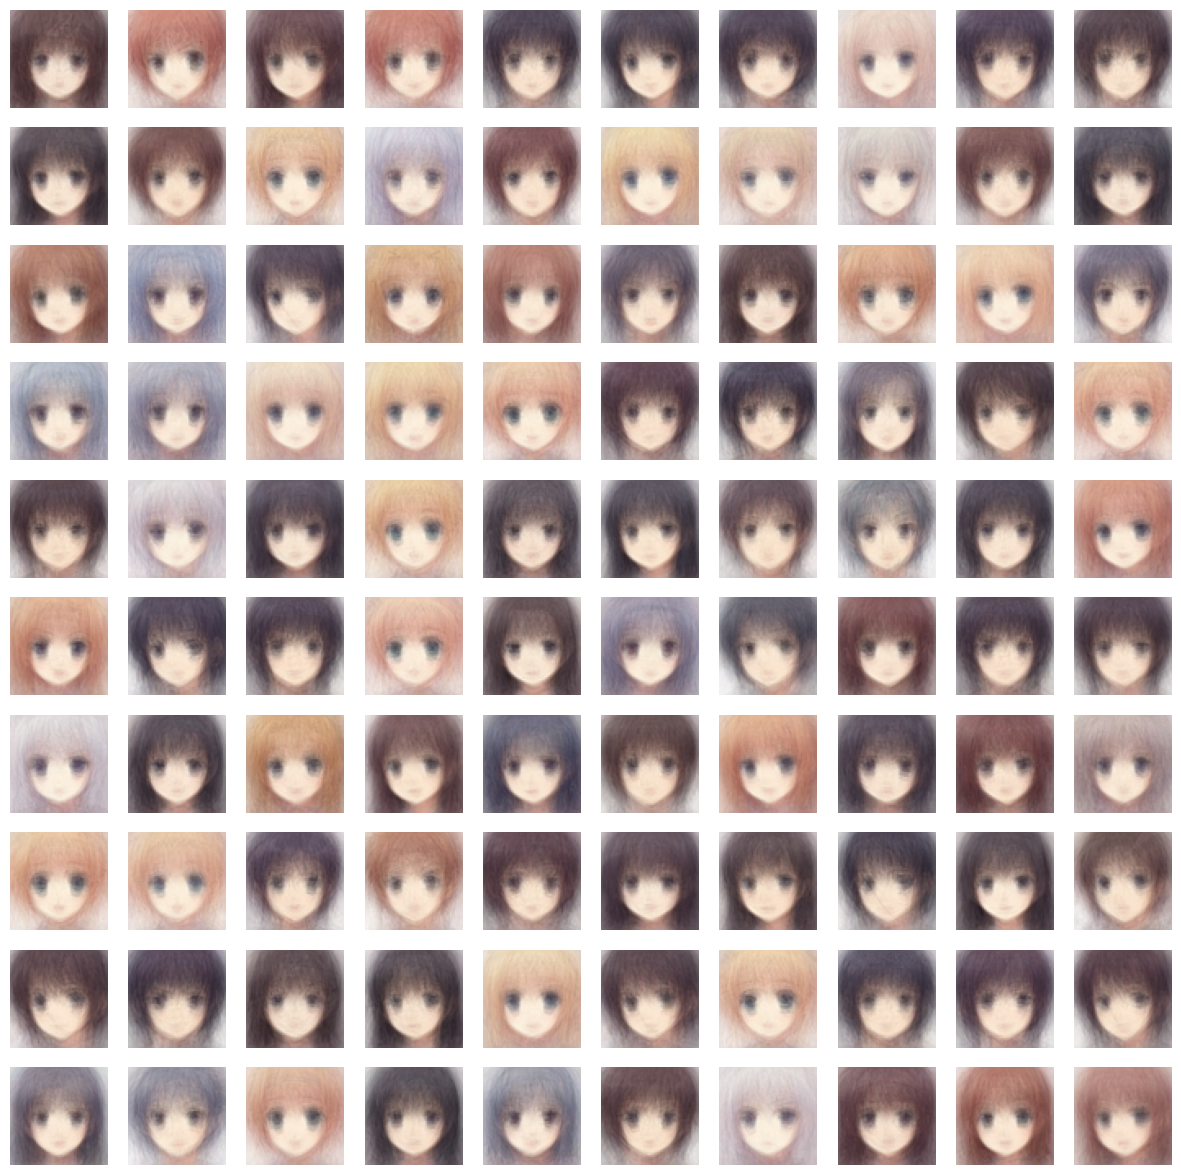

In [37]:
m = 100
threshold = 80
std_dev = 0.05

# cov_matrix = np.identity(latent_dim) * std_dev
# input = np.array([[np.random.multivariate_normal(random.choice(X), cov_matrix)] for i in range(m)]).reshape(m, -1)

input = np.array([[random.uniform(0, 1) for j in range(latent_dim)] for i in range(m)])

y_pred = rf.predict(input)
y_pred = y_pred.reshape(m, image_size, image_size, 3)
pil_img = [Image.fromarray(np.uint8(img*255)) for img in y_pred]
sharp_img = [pil_img.filter(ImageFilter.SHARPEN) for pil_img in pil_img]
y_pred = [np.array(pil_img)/255 for pil_img in sharp_img]

fig, axs = plt.subplots(m//10, 10, figsize=(15, 15))
axs = axs.flatten()
# Plot data on the subplots
for i in range(m):
    axs[i].imshow(y_pred[i])
    axs[i].axis('off')  # Turn off axis labels and ticks
